In [23]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch
from copy import deepcopy
from lightning_lite.utilities.seed import seed_everything
plt.style.use("fivethirtyeight")

In [24]:
mdataset_train = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
fdataset_train = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor(),
    target_transform=lambda x: x + 10)


mdataset_test = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())
fdataset_test = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor(),
    target_transform=lambda x: x + 10)

In [25]:
print(len(mdataset_train), len(fdataset_train), len(mdataset_test), len(fdataset_test))

60000 60000 10000 10000


In [26]:
dataset_train = torch.utils.data.ConcatDataset([mdataset_train, fdataset_train])
dataset_stream_idx = torch.randperm(len(dataset_train))

In [27]:
import torch.nn as nn

class MNISTNet(nn.Module):
    def __init__(self, X_test, y_test) -> None:
        super().__init__()
        self.num_classes = 20
        self.embedding = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.model = nn.Sequential(
            nn.Linear(4 * 7 * 7, 64),
            nn.ReLU(),
            nn.Linear(64, self.num_classes),
        )

        self.criteria = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        print("Num parameters:", sum(p.numel() for p in self.parameters()))
        self.X_test = X_test.to('cuda')
        self.y_test = y_test.to('cuda')
        self.to('cuda')
    
    def forward(self, x):
        x = x.to('cuda')
        x = self.embedding(x)
        x = x.view(-1, 4 * 7 * 7)
        x = self.model(x)
        return x
    
    def train_step(self, x, y):
        y = y.to('cuda')
        self.train()
        self.optimizer.zero_grad()
        y_hat = self(x)
        loss = self.criteria(y_hat, y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def test_step(self):
        self.eval()
        with torch.no_grad():
            y_hat = self(self.X_test)
            loss = self.criteria(y_hat, self.y_test)
            return loss.item()
    
    
    def evaluate_usefulness(self, X, ys):
        # for each (x, y) in X, ys, evaluate the usefulness of the point
        # slow and noisy
        batch_size = X.shape[0]
        losses = []
        for i in range(batch_size):
            x = X[i]
            y = ys[i]
            net_copy = deepcopy(self)
            x = x.unsqueeze(0)
            y = y.unsqueeze(0)
            net_copy.train_step(x, y)
            losses.append(net_copy.test_step())
        return torch.tensor(losses)

    def evaluate_usefulnessv1(self, X, ys):
        # leave one out: less noisy, very slow.
        batch_size = X.shape[0]
        net_copy = deepcopy(self)
        net_copy.train_step(X, ys)
        fitted_all = net_copy.test_step()
        improvs = []
        for i in range(batch_size):
            net_copy_leave_one = deepcopy(self)
            # leave data point i out and fit the model
            # on the rest of the data
            X_leave_one = torch.cat([X[:i], X[i+1:]])
            ys_leave_one = torch.cat([ys[:i], ys[i+1:]])
            net_copy_leave_one.train_step(X_leave_one, ys_leave_one)
            fitted_leave_one = net_copy_leave_one.test_step()
            improvs.append(fitted_leave_one - fitted_all)
        return torch.tensor(improvs)
    
    def evaluate_usefulnessv2(self, batch_x, batch_y):
        batch_z = batch_y.clone()
        batch_z.apply_(lambda x: x // 10)
        before_loss = self.test_step()

        net_copy0 = deepcopy(self)
        batch_x0 = batch_x[batch_z == 0]
        batch_y0 = batch_y[batch_z == 0]
        net_copy0.train_step(batch_x0, batch_y0)
        test_loss0 = net_copy0.test_step()

        net_copy1 = deepcopy(self)
        batch_x1 = batch_x[batch_z == 1]
        batch_y1 = batch_y[batch_z == 1]
        net_copy1.train_step(batch_x1, batch_y1)
        test_loss1 = net_copy1.test_step()

        return before_loss - test_loss0, before_loss - test_loss1



In [28]:
# test on MNIST
X_test = torch.stack([x for x, _ in mdataset_test])
y_test = torch.tensor([y for _, y in mdataset_test])
print(X_test.shape, y_test.shape)

torch.Size([10000, 1, 28, 28]) torch.Size([10000])


See if the test improvement metric makes sense!

In [30]:
seed_everything(0)
net = MNISTNet(X_test, y_test)

batch_size = 64
max_steps = len(dataset_train) // batch_size
max_steps = 1
log_interval = 1

train_losses = []
test_losses = [net.test_step()]
test_improvs = []
batch_improvs_task0 = []
batch_improvs_task1 = []

print(f"Before training test loss: {test_losses[0]:.3f}")
for env_step in range(max_steps):
    batch_idx = dataset_stream_idx[env_step * batch_size:(env_step + 1) * batch_size]
    batch = [dataset_train[i] for i in batch_idx]
    batch_x = torch.stack([x for x, _ in batch])
    batch_y = torch.tensor([y for _ , y in batch])

    batch_z = batch_y.clone()
    batch_z.apply_(lambda x: x // 10)
    print(batch_z)
    # batch_x = batch_x[batch_z == 1]
    # batch_y = batch_y[batch_z == 1]
    batch_losses = net.evaluate_usefulnessv1(batch_x, batch_y)
    print(batch_losses)
    # test_loss0, test_loss1 = net.evaluate_usefulnessv1(batch_x, batch_y)
    # print(test_loss0, test_loss1)
    # batch_improvs_task0.append(test_loss0)
    # batch_improvs_task1.append(test_loss1)

    # print("batch_improvs:")
    # print("\t", batch_improvs)
    # print("batch_improvs task 0")
    # print("\t", batch_improvs[batch_z == 0], batch_improvs[batch_z == 0].mean())
    # print("batch_improvs task 1")
    # print("\t", batch_improvs[batch_z == 1], batch_improvs[batch_z == 1].mean())
    # batch_improvs_task0.append(batch_improvs[batch_z == 0].mean())
    # batch_improvs_task1.append(batch_improvs[batch_z == 1].mean())

    # improvs = 1.0 - (improvs / improvs.max())
    # print(batch_losses)
    # print("avg 0 loss:", batch_losses[batch_z == 0].mean())
    # print("avg 1 loss:", batch_losses[batch_z == 1].mean())
    # print("diff loss:", batch_losses[batch_z == 1].mean() - batch_losses[batch_z == 0].mean())

    train_loss = net.train_step(batch_x, batch_y)
    test_loss = net.test_step()
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_improv = test_losses[-2] - test_losses[-1]
    test_improvs.append(test_improv)
    if env_step % log_interval == 0:
        print(f"Step {env_step}/{max_steps}: train loss {train_loss:.3f}, test loss {test_loss:.3f} test_improv {test_improv:.3f}")

Global seed set to 0


Num parameters: 14648
Before training test loss: 2.990
tensor([1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1])
tensor([-2.0647e-04,  1.3828e-05, -1.3280e-04, -5.2929e-05,  5.6982e-05,
        -7.3910e-05,  6.7711e-05,  5.2691e-05,  7.3910e-06,  4.2939e-04,
        -2.7990e-04,  7.5817e-05,  6.9141e-06,  9.5367e-07,  4.0674e-04,
         1.7524e-04,  2.3103e-04,  4.3511e-04,  2.8610e-04,  1.7595e-04,
         3.2425e-05,  4.5061e-05,  2.6965e-04, -5.5313e-05, -1.4615e-04,
         3.8362e-04,  2.5892e-04, -6.1750e-05,  2.6083e-04, -9.0599e-06,
         1.7357e-04,  1.8787e-04,  8.3208e-05,  2.7227e-04,  2.0051e-04,
         5.3406e-05,  3.4809e-05, -4.0293e-05,  3.5787e-04, -1.3852e-04,
         5.8413e-05, -6.8903e-05, -1.9550e-05,  3.3450e-04,  6.1274e-05,
        -2.6846e-04,  1.4567e-04,  8.9407e-05, -3.1471e-05, -1.5807e-04

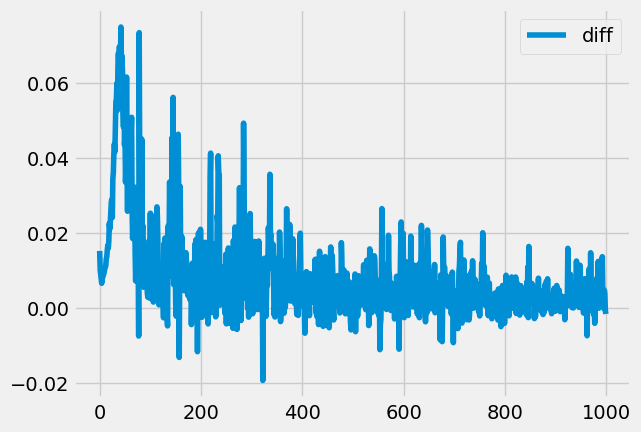

In [18]:
batch_improvs_task0 = torch.tensor(batch_improvs_task0)
batch_improvs_task1 = torch.tensor(batch_improvs_task1)
# plt.plot(batch_improvs_task0, label="task 0")
# plt.plot(batch_improvs_task1, label="task 1")
plt.plot(batch_improvs_task0 - batch_improvs_task1, label="diff")
plt.legend();

In [22]:
diff = batch_improvs_task0 - batch_improvs_task1

In [ ]:
np.mean(test_improvs)

In [ ]:
# plt.plot(train_losses, label="train")
# plt.plot(test_losses, label="test")
plt.plot(test_improvs, label="test_improv")
plt.legend();